<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/mhealth_LSTM_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# -------------------------
# 0. 공통 세팅
# -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET"

COLS = ["ch_ax","ch_ay","ch_az","ecg1","ecg2",
        "ank_ax","ank_ay","ank_az","ank_gx","ank_gy","ank_gz",
        "ank_mx","ank_my","ank_mz",
        "arm_ax","arm_ay","arm_az","arm_gx","arm_gy","arm_gz",
        "arm_mx","arm_my","arm_mz",
        "label"]

In [9]:
# 1. 데이터 로드
# -------------------------
dfs = []
for s in range(1, 11):
    fp = os.path.join(DATA_DIR, f"mHealth_subject{s}.log")
    df = pd.read_csv(fp, sep="\t", header=None, names=COLS, engine="python")
    df["subject"] = s
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print("df_all:", df_all.shape)
print("라벨 분포:\n", df_all["label"].value_counts().sort_index())
print("\nsubject별 샘플 수:\n", df_all.groupby("subject").size())

df_all: (1215745, 25)
라벨 분포:
 label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: int64

subject별 샘플 수:
 subject
1     161280
2     130561
3     122112
4     116736
5     119808
6      98304
7     104448
8     129024
9     135168
10     98304
dtype: int64


In [10]:
# 2. 윈도 생성 (subject-wise 정규화)
# -------------------------
WIN = 128
STEP = 32          # 더 많은 윈도
FEATS = [c for c in COLS if c != "label"]

def make_windows_subjectwise(df):
    X_list, y_list, sub_list = [], [], []
    for sid, d in df.groupby("subject"):
        sig = d[FEATS].to_numpy(dtype=np.float32)
        lab = d["label"].to_numpy(dtype=np.int16)

        # subject 안에서만 정규화
        mu = sig.mean(axis=0, keepdims=True)
        sd = sig.std(axis=0, keepdims=True) + 1e-7
        sig = (sig - mu) / sd

        for i in range(0, len(d) - WIN + 1, STEP):
            j = i + WIN
            X_list.append(sig[i:j])
            y_list.append(np.bincount(lab[i:j]).argmax())
            sub_list.append(sid)
    return np.asarray(X_list), np.asarray(y_list), np.asarray(sub_list)

df_use = df_all[df_all["label"] != 0].reset_index(drop=True)
X_all, y_all_raw, subs_all = make_windows_subjectwise(df_use)

# 라벨 0~(C-1)
le = LabelEncoder()
y_all = le.fit_transform(y_all_raw)
class_ids = list(range(len(le.classes_)))
class_names = [str(c) for c in le.classes_]
num_classes = len(class_ids)

print("윈도 개수:", X_all.shape)
print("클래스:", class_names)

input_shape = (WIN, len(FEATS))

윈도 개수: (10690, 128, 23)
클래스: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


In [11]:
# 3. 모델
# -------------------------
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization

def build_lstm(input_shape, num_classes):
    inp = keras.Input(input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out, name="LSTM")

In [12]:
# 4. label smoothing이 들어간 sparse loss (우리 버전용)
# -------------------------
def sparse_ce_with_ls(label_smoothing=0.1):
    def loss_fn(y_true, y_pred):
        # y_true: (batch,)
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        num_classes = tf.shape(y_pred)[-1]
        y_true_onehot = tf.one_hot(y_true, num_classes)
        # smooth
        ls = tf.cast(label_smoothing, tf.float32)
        y_true_ls = y_true_onehot * (1.0 - ls) + ls / tf.cast(num_classes, tf.float32)
        return tf.keras.losses.categorical_crossentropy(y_true_ls, y_pred)
    return loss_fn

In [13]:
# 5. CM 유틸
# -------------------------
def plot_confusion_matrix(cm, labels, title="Confusion Matrix", normalize=True):
    cm_disp = cm.astype(np.float32)
    if normalize:
        cm_disp = cm_disp / (cm_disp.sum(axis=1, keepdims=True) + 1e-9)
    plt.figure(figsize=(6,5))
    plt.imshow(cm_disp, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels)
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout()

class_weights (non-CV): {0: np.float64(0.9203924490809736), 1: np.float64(0.91765725606736), 2: np.float64(0.9203924490809736), 3: np.float64(0.9190228174603174), 4: np.float64(0.9357323232323232), 5: np.float64(1.0414558740865656), 6: np.float64(0.9944981213097155), 7: np.float64(1.0025703463203464), 8: np.float64(0.9190228174603174), 9: np.float64(0.9190228174603174), 10: np.float64(0.9190228174603174), 11: np.float64(2.8329510703363914)}
Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.4653 - loss: 1.8769 - val_accuracy: 0.8230 - val_loss: 1.1868
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9132 - loss: 0.8511 - val_accuracy: 0.8857 - val_loss: 1.1458
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9690 - loss: 0.7147 - val_accuracy: 0.8321 - val_loss: 1.1620
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9515 - loss: 0.7285 - val_accuracy: 0.8893 - val_loss: 1.0709
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/s

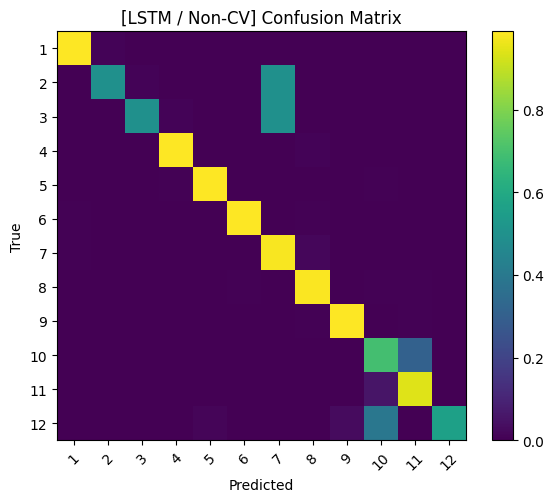

In [14]:
# 6. Non-CV
# -------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=subs_all))

X_tr_full, X_te = X_all[train_idx], X_all[test_idx]
y_tr_full, y_te = y_all[train_idx], y_all[test_idx]
subs_tr_full = subs_all[train_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
train_idx2, val_idx = next(gss_val.split(X_tr_full, y_tr_full, groups=subs_tr_full))
X_tr, X_va = X_tr_full[train_idx2], X_tr_full[val_idx]
y_tr, y_va = y_tr_full[train_idx2], y_tr_full[val_idx]

# 클래스 가중치
cw = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_tr),
    y=y_tr
)
class_weights = dict(enumerate(cw))
print("class_weights (non-CV):", class_weights)

optimizer = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
loss_fn = sparse_ce_with_ls(label_smoothing=0.1)

lstm = build_lstm(input_shape, num_classes)
lstm.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(
    patience=6, restore_best_weights=True, monitor="val_loss"
)

lstm.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=30,
    batch_size=128,
    callbacks=[es],
    class_weight=class_weights,
    verbose=1
)

y_pred = lstm.predict(X_te, verbose=0).argmax(axis=1)
print("\n[LSTM / Non-CV] macroF1:",
      f1_score(y_te, y_pred, average="macro", labels=class_ids))
print(classification_report(y_te, y_pred, digits=4, target_names=class_names))
cm = confusion_matrix(y_te, y_pred, labels=class_ids)
plot_confusion_matrix(cm, class_names, title="[LSTM / Non-CV] Confusion Matrix", normalize=True)
plt.show()


===== CV Fold: test subjects (1, 2) =====
Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4891 - loss: 1.8378 - val_accuracy: 0.9164 - val_loss: 0.7886
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9124 - loss: 0.8532 - val_accuracy: 0.9753 - val_loss: 0.6410
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9688 - loss: 0.7092 - val_accuracy: 0.9812 - val_loss: 0.6116
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9803 - loss: 0.6654 - val_accuracy: 0.9859 - val_loss: 0.5903
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9843 - loss: 0.6411 - val_accuracy: 0.9847 - val_loss: 0.5820
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9834 - loss: 0.6352 - val_accuracy: 0.9859 - val_loss: 0.5907
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9843 - loss: 0.6332 - val_accuracy: 0.9847 - val_loss: 0.5838
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.983

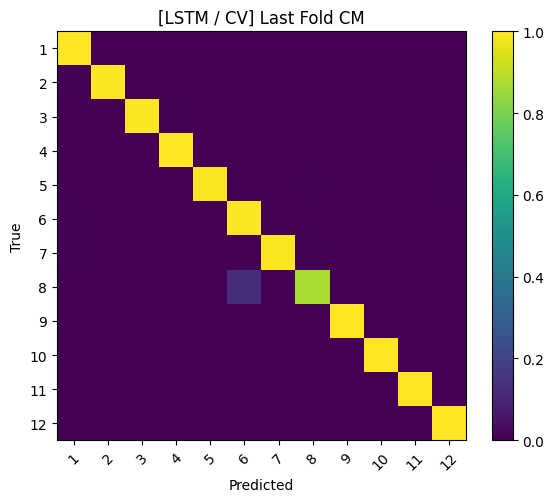

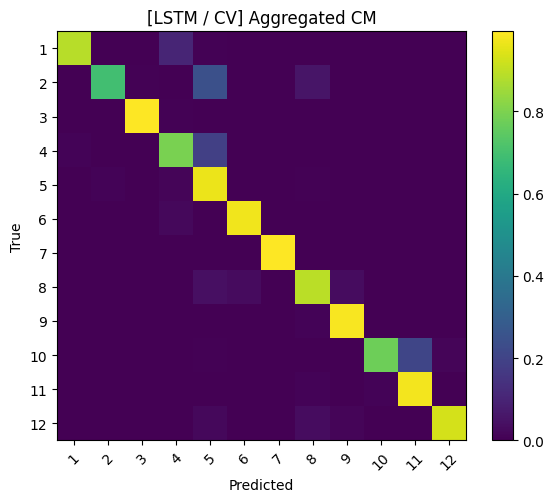

In [15]:
# 7. 5쌍 CV
# -------------------------
PAIRS = [(1,2),(3,4),(5,6),(7,8),(9,10)]
f1_list = []
agg_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
last_cm = None

for pair in PAIRS:
    print(f"\n===== CV Fold: test subjects {pair} =====")
    test_mask = np.isin(subs_all, pair)
    X_te_cv, y_te_cv = X_all[test_mask], y_all[test_mask]
    X_tr_full_cv, y_tr_full_cv = X_all[~test_mask], y_all[~test_mask]

    X_tr_cv, X_va_cv, y_tr_cv, y_va_cv = train_test_split(
        X_tr_full_cv, y_tr_full_cv,
        test_size=0.1,
        random_state=SEED,
        stratify=y_tr_full_cv
    )

    # fold별 클래스 가중치
    cw_cv = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_tr_cv),
        y=y_tr_cv
    )
    class_weights_cv = dict(enumerate(cw_cv))

    model = build_lstm(input_shape, num_classes)
    model.compile(
        optimizer=keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
        loss=sparse_ce_with_ls(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    es_cv = keras.callbacks.EarlyStopping(
        patience=6, restore_best_weights=True, monitor="val_loss"
    )

    model.fit(
        X_tr_cv, y_tr_cv,
        validation_data=(X_va_cv, y_va_cv),
        epochs=30,
        batch_size=128,
        callbacks=[es_cv],
        class_weight=class_weights_cv,
        verbose=1
    )

    y_pred_cv = model.predict(X_te_cv, verbose=0).argmax(axis=1)
    f1 = f1_score(y_te_cv, y_pred_cv, average="macro", labels=class_ids)
    f1_list.append(f1)
    print(f"[LSTM / CV][test {pair}] macroF1={f1:.4f}")

    cm_cv = confusion_matrix(y_te_cv, y_pred_cv, labels=class_ids)
    agg_cm += cm_cv
    last_cm = cm_cv

print("\n[LSTM / CV] 5-fold macroF1 평균:", round(np.mean(f1_list),4),
      " | folds:", [round(x,4) for x in f1_list])

plot_confusion_matrix(last_cm, class_names, title="[LSTM / CV] Last Fold CM", normalize=True)
plt.show()
plot_confusion_matrix(agg_cm, class_names, title="[LSTM / CV] Aggregated CM", normalize=True)
plt.show()